# Cross Validation
## With and without cross_val_score()
The purpose of this notebook is to demonstrate what cross_val_score() does behind the scenes, and to prepare for the following notebook on GridSearchCV.

The [King County housing price dataset](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.

A simple model will be created to demonstrate how a pipeline is cross validated.

Hyperparameter values will be specified, but not optimized.  In the next notebook, they will be optimized.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [2]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)
all_data.shape

(21613, 21)

## EDA

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


There are no missing values and there are no variables of type 'object'.

In [4]:
# median house price
all_data['price'].median()

450000.0

In [5]:
print(all_data['date'].min())
print(all_data['date'].max())

2014-05-02 00:00:00
2015-05-27 00:00:00


There is just over 1 year's worth of data.

In [6]:
# group by week
weekly = all_data.groupby(pd.Grouper(key='date', freq='W'))

In [7]:
# get weekly sales count and median weekly sales price
weekly_count = weekly['price'].count()
weekly_price = weekly['price'].apply(np.median)

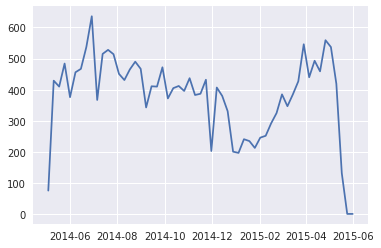

In [8]:
plt.plot(weekly_count)

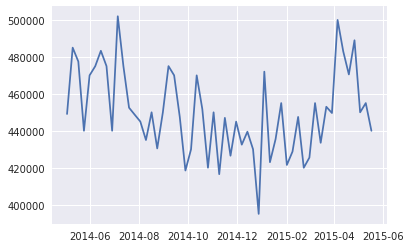

In [9]:
# filter out weeks with very few sales and plot median price
weekly_price = weekly_price[weekly_count >= 10]
plt.plot(weekly_price)

The two plots above do not show any obvious time-series trends for either the number of sales per week or the median house sale price per week.  Let's ignore date.

In [10]:
print(f'Num Unique ids: {all_data["id"].nunique()}')
print(f'Num Records: {all_data["id"].count()}')

Num Unique ids: 21436
Num Records: 21613


Not all the ids are unique.  Let's examine a few of the records with duplicate ids.

In [11]:
all_data.groupby(['id']).filter(lambda x: len(x) > 1).head(4)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
313,4139480200,2014-06-18,1384000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244


This dataset is of sales transactions.  Each sale is a record.  The same house may be sold more than once.

To predict the price for a house, we want a dataset of houses, where each house is a record.

Let's replace sale price with the average sale price per house.  This will create duplicate records.  Remove these duplicates and now we have a dataset of houses.

In [12]:
# compute mean price per id
mean_price_by_id = all_data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
all_data = all_data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

In [13]:
# look at 2 records to verify above code
all_data[all_data['id'].isin([6021501535, 4139480200])]

,id,date,price_orig,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_mean
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0,0,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,565000.0
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0,0,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,565000.0
313,4139480200,2014-06-18,1384000.0,4,3.25,4290,12103,1.0,0,3,...,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244,1392000.0
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0,3,...,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244,1392000.0


In [14]:
# drop records with duplicate ids and drop the original price
all_data = all_data.drop('price_orig', axis=1).drop_duplicates(subset='id')

In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 0 to 21612
Data columns (total 21 columns):
id               21436 non-null int64
date             21436 non-null datetime64[ns]
bedrooms         21436 non-null int64
bathrooms        21436 non-null float64
sqft_living      21436 non-null int64
sqft_lot         21436 non-null int64
floors           21436 non-null float64
waterfront       21436 non-null int64
view             21436 non-null int64
condition        21436 non-null int64
grade            21436 non-null int64
sqft_above       21436 non-null int64
sqft_basement    21436 non-null int64
yr_built         21436 non-null int64
yr_renovated     21436 non-null int64
zipcode          21436 non-null int64
lat              21436 non-null float64
long             21436 non-null float64
sqft_living15    21436 non-null int64
sqft_lot15       21436 non-null int64
price_mean       21436 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.6 MB


In [16]:
# remove id and date fields
all_data = all_data.drop(['id', 'date'], axis=1)

Examine yr_built and yr_renovated

In [17]:
all_data[['yr_built','yr_renovated']].head(3)

,yr_built,yr_renovated
0,1955,0
1,1951,1991
2,1933,0


Replace yr_built with yr_renovated if yr_renovated is not 0.

In [18]:
# repace yr_built with yr_renovated if yr_renovated != 0
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']
all_data = all_data.drop('yr_renovated',axis=1)

Examine zipcode

In [19]:
all_data['zipcode'].nunique()

70

There are 70 unique values. This is probably too many to one hot encode.

Much of the information in zipcode may be contained in lat and lon.  No doubt there is additional valuable information in zipcode, but for this notebook, it will be dropped.

In [20]:
all_data = all_data.drop(['zipcode'], axis=1)

There are other categorical variables, such as waterfront, view, condition, grade, etc., but these seem to be ordered categorical variables encoded as integers, so leave them as is.

In [21]:
all_data.head(3)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,price_mean
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650,221900.0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1991,47.7210,-122.319,1690,7639,538000.0
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062,180000.0


This is enough preprocessing to build a reasonable model with.

In [22]:
X_all = all_data.drop('price_mean', axis=1)
y_all = all_data['price_mean']
print(X_all.shape)
print(y_all.shape)

(21436, 16)
(21436,)


## Model Building
A simple model will be built using KNN.  KNN suffers from the "curse of dimensionality", so the dimensionality of the feature set will be reduced with PCA.  PCA expects variables to be on the same scale, so the feature will be standardized prior to input to PCA.

### Cross Validation using Pipeline with cross_value_score

In [23]:
# Setup for Cross Validation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error

# arbitrarily choose a model with 8 PCA components and 4 neighbors
scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

# use explict CV generator for repeatability
k_folds = 10
random_seed=5
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [24]:
# typical way cross validation is performed
pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

scores = cross_val_score(pipe, X_all, y_all, cv=cv, 
                         scoring='neg_mean_squared_error', n_jobs=1)

# RMSE
rmse = np.sqrt(np.abs(scores)).mean()
rmse

164197.60344784713

#### RMSE Computation
RMSE is easier to think about than MSE because it is on the same scale as the data.  Note the median sales price of a house is 450,000.

In [25]:
# correct for mse
mse = np.abs(scores.mean())
mse

27117252626.115288

In [26]:
# tempting, but incorrect
rmse_wrong = np.sqrt(mse)
rmse_wrong

164673.16911420418

In [27]:
# correct rmse computation
# consider each CV fold to produce an estimate of the RMSE and average these
cv_rmse_scores = np.sqrt(np.abs(scores))
rmse = cv_rmse_scores.mean()
print(rmse)

164197.60344784713


In [28]:
# correct for standard deviation of mse
mse_std = scores.std()
mse_std

4225496073.208892

In [29]:
# tempting, but incorrect
rmse_std_wrong = np.sqrt(mse_std)
rmse_std_wrong

65003.815835756075

In [30]:
# correct for standard deviation of rmse
cv_rmse_scores = np.sqrt(np.abs(scores))
rmse_std = cv_rmse_scores.std()
rmse_std

12505.984491387466

The correct calculation for standard deviation of the rmse is very different than the incorrect calculation.

### Cross Validation without Pipeline or cross_value_score
The following produces exactly the same result as above.  It takes many more lines of code, but it is instructive for understanding how cross_value_score is using the pipeline behind the scences.

In [31]:
# replace cross_val_score with the following for-loop, no pipeline
my_scores = []
for train_idx, test_idx in cv.split(X_all):
    
    # train
    X_train = X_all.iloc[train_idx, :]
    y_train = y_all.values[train_idx]
    
    X_train_std = scale.fit_transform(X_train)
    X_train_std_pca = pca.fit_transform(X_train_std)
    
    # test
    X_test = X_all.iloc[test_idx, :]
    y_test = y_all.values[test_idx]
    
    X_test_std = scale.transform(X_test)
    X_test_std_pca = pca.transform(X_test_std)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_squared_error(y_test, predictions))

# print results
rmse2 = np.sqrt(np.abs(my_scores)).mean()
print(rmse == rmse2)

True


The above code produces exactly the same result as the more concise code that used a pipeline and cross_val_score().

In [32]:
# replace cross_val_score with the following for-loop, pipeline for preprocesing
pipe = Pipeline(steps=[('scale', scale),('pca',pca)])

my_scores = []
for train_idx, test_idx in cv.split(X_all):
    
    # train
    X_train = X_all.iloc[train_idx, :]
    y_train = y_all.values[train_idx]
    
    X_train_std_pca = pipe.fit_transform(X_train)
    
    # test
    X_test = X_all.iloc[test_idx, :]
    y_test = y_all.values[test_idx]
    
    X_test_std_pca = pipe.transform(X_test)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_squared_error(y_test, predictions))

# print results
rmse3 = np.sqrt(np.abs(my_scores)).mean()
print(rmse == rmse3)

True


#### Dimensionality

In [33]:
# Examine magnitude of each coordinate in the transformed feature space
features_transformed = pca.fit_transform(scale.fit_transform(X_all))

# mean of squared coordinate values
coordinate_mag = (features_transformed * features_transformed).mean(axis=0)
np.round(coordinate_mag, 2)

array([5.14, 2.  , 1.81, 1.28, 1.05, 0.87, 0.78, 0.66])

The original input data had 21 features, which is likely too many for KNN.

The top 8, by variance explained, PCA transformed features were chosen for use in this model. 8 is more reasonable for KNN than 21.

The KNN model is using Euclidean distance, which is the square-root of the sum of the squared distances along each dimension.  Each point in the transformed feature space is represented, on average, by a smaller coordinate in a higher dimension.  This reduces the effective size of the feature space (as measured by Euclidean distance).  In other words, there are effectively less than 8 dimensions, which is better for KNN.